Test of Style Transfer

refer to::
https://github.com/udacity/deep-learning-v2-pytorch/tree/master/style-transfer

refer to::
https://elix-tech.github.io/ja/2016/08/22/art.html


In [1]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import transforms, models

In [2]:
data_dir = '../data/' # The folder we will use for storing data
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def load_image(img_path, max_size=400, shape=None):    
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [4]:
input_image_name = 'mychild.jpg'
refernce_image_name = 'illustration.jpg'

In [5]:
# load in content and style image
content = load_image(os.path.join(data_dir, input_image_name)).to(device)
# Resize style to match content, makes code easier
style = load_image(os.path.join(data_dir, refernce_image_name), shape=content.shape[-2:]).to(device)

In [6]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

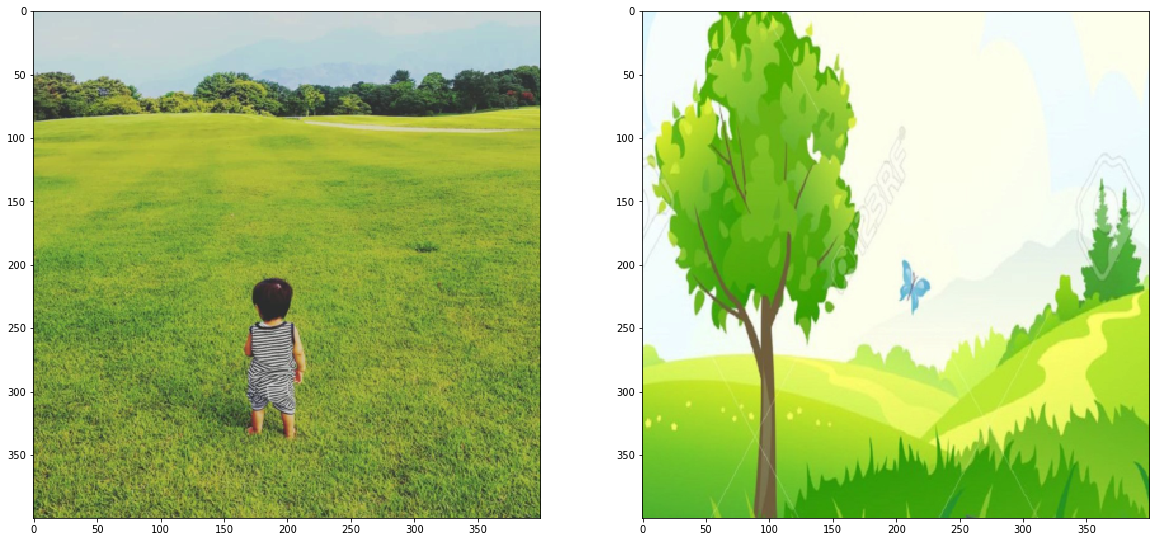

In [7]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [8]:
!pygmentize scripts/train.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data
import numpy as np
import PIL.Image
from torchvision import transforms, models


from model import BasementModel

def model_fn(model_dir):
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BasementModel()#kara

    model.to(device).eval()

    print("Done loading model.")
    return model


def train(model, target, content_features, style_features, style_grams, epochs, optimizer ):
    
    show_every = int(args.epochs / 10)
    
   

In [9]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/style_transfer'

role = sagemaker.get_execution_role()

In [10]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [11]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="scripts",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',#'ml.m4.xlarge',#
                    hyperparameters={
                        'epochs'               : 500,
                        'input_image_name'     : input_image_name,
                        'reference_image_name' : refernce_image_name
                    })


In [ ]:
estimator.fit({'training': input_data})

2019-06-03 14:17:25 Starting - Starting the training job...
2019-06-03 14:17:38 Starting - Launching requested ML instances...

In [ ]:
resultImg = Image.open(os.path.join(data_dir, 'result.jpg')).convert('RGB')

# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(resultImg)